## Runtime Configuration

In [18]:
# User-configurable parameters
symbols_to_predict = ['EURUSD=X', 'GBPUSD=X']
date_start = '2015-01-01'
date_end = '2024-01-01'
lookback_window = 20  # Number of days for the rolling input window
nudge = True


In [19]:
for symbol_to_predict in symbols_to_predict:
    print(f"\n🔁 Processing symbol: {symbol_to_predict}")



🔁 Processing symbol: EURUSD=X

🔁 Processing symbol: GBPUSD=X


# 📈 CNN + LSTM Forex Prediction using RCS + Technical Indicators
This notebook builds a CNN+LSTM hybrid model to predict EURUSD price direction using Relative Currency Strength and common technical indicators.

# Step 1: Install and Import Required Libraries

In [20]:
    %pip install ta scikit-learn pandas numpy matplotlib seaborn metatrader5 tensorflow tables keras2onnx tf2onnx shap

    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import ta
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split, TimeSeriesSplit
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, concatenate
    import MetaTrader5 as mt5

Note: you may need to restart the kernel to use updated packages.


## Stage 2: Load all required symbols from MetaTrader 5 and build a prices DataFrame (fixed loader_func)

In [21]:
# --- Data Loading: Use load_or_fetch (with load_metatrader_data) for all symbols, build MultiIndex prices DataFrame ---

from async_data_loader import load_or_fetch, load_metatrader_data
import pandas as pd

symbols = ["EURUSD", "GBPUSD", "USDJPY", "AUDUSD", "USDCAD", "EURJPY", "GBPJPY"]
provider = "metatrader"
broker = "amp_global"
interval = "H1"

data = {}
for sym in symbols:
    df = load_or_fetch(
        symbol=sym,
        provider=provider,
        loader_func=load_metatrader_data,
        api_key="",
        interval=interval,
        broker=broker,
        force_refresh=False,
    )
    if "time" in df.columns and "close" in df.columns:
        df = df[["time", "open", "high", "low", "close", "tick_volume"]].dropna()
        df["time"] = pd.to_datetime(df["time"])
        df = df.set_index("time")
        for col in ["open", "high", "low", "close", "tick_volume"]:
            data[(sym, col)] = df[col]

prices = pd.DataFrame(data)
print(prices.head())
# prices now has MultiIndex columns: (symbol, field)


✅ Loaded cached data from data/metatrader_EURUSD.parquet
✅ Loaded cached data from data/metatrader_GBPUSD.parquet
✅ Loaded cached data from data/metatrader_USDJPY.parquet
✅ Loaded cached data from data/metatrader_AUDUSD.parquet
✅ Loaded cached data from data/metatrader_USDCAD.parquet
✅ Loaded cached data from data/metatrader_EURJPY.parquet
✅ Loaded cached data from data/metatrader_GBPJPY.parquet
                      EURUSD                                        USDJPY  \
                        open     high      low    close tick_volume   open   
time                                                                         
2023-06-09 04:00:00  1.07820  1.07851  1.07796  1.07806      1782.0    NaN   
2023-06-09 05:00:00  1.07806  1.07811  1.07757  1.07768      1398.0    NaN   
2023-06-09 06:00:00  1.07768  1.07802  1.07766  1.07778      1104.0    NaN   
2023-06-09 07:00:00  1.07778  1.07786  1.07747  1.07754       834.0    NaN   
2023-06-09 08:00:00  1.07755  1.07841  1.07754  1.07780

## Step 3: Calculate Log Returns and Relative Currency Strength (RCS)

In [22]:
    def compute_rcs(logrets):
        currencies = list(set([s[:3] for s in logrets.columns] + [s[3:6] for s in logrets.columns]))
        rcs_data = {c: [] for c in currencies}
        for i in range(len(logrets)):
            row = logrets.iloc[i]
            daily_strength = {c: 0 for c in currencies}
            counts = {c: 0 for c in currencies}
            for pair, ret in row.items():
                base, quote = pair[:3], pair[3:]
                daily_strength[base] += ret
                daily_strength[quote] -= ret
                counts[base] += 1
                counts[quote] += 1
            for c in currencies:
                avg = daily_strength[c] / counts[c] if counts[c] else 0
                rcs_data[c].append(avg)
        return pd.DataFrame(rcs_data, index=logrets.index)

    log_returns = np.log(prices / prices.shift(1)).dropna()
    rcs = compute_rcs(log_returns)
    rcs.head()

USDJPY    USDCAD    EURUSD    USDCAD      USDJPY      EURUSD  \
                 low      open       low      high tick_volume tick_volume   
time                                                                         
2024-12-26 -0.000006  0.001115  0.000866  0.004943    8.348538    3.704042   

              USDJPY              EURUSD    USDCAD    EURUSD      USDCAD  \
               close      open     close       low      open tick_volume   
time                                                                       
2024-12-26  0.005492  0.000083  0.000423 -0.000816  0.001154    6.910044   

              USDJPY       NaN    USDCAD   EURUSD  
                high       NaN     close     high  
time                                               
2024-12-26  0.005646 -1.265733  0.003736  0.00074

## Step 4: Calculate Technical Indicators

In [23]:
# --- Feature Engineering using engineer_features from feature_engineering.py ---

from feature_engineering import engineer_features

symbol = "EURUSD"
features = engineer_features(prices, symbol)
print(features.head())


                           rsi      macd  momentum         cci       atr  \
time                                                                       
2023-06-12 05:00:00  31.771996 -0.000881 -0.170125 -118.625425  0.000887   
2023-06-12 06:00:00  34.909370 -0.000867 -0.067918  -95.231219  0.000860   
2023-06-12 07:00:00  35.043400 -0.000846 -0.067918  -77.367399  0.000837   
2023-06-12 08:00:00  45.037563 -0.000754  0.005582  -33.933946  0.000848   
2023-06-12 09:00:00  45.037563 -0.000673 -0.004651   -6.730373  0.000846   

                           adx    stoch_k    stoch_d       roc       bbw  ...  \
time                                                                      ...   
2023-06-12 05:00:00   0.000000  13.002364   6.680063 -0.170125  0.414339  ...   
2023-06-12 06:00:00   0.000000  19.554455  11.337374 -0.067918  0.381928  ...   
2023-06-12 07:00:00  26.635786  29.850746  20.802522 -0.067918  0.379116  ...   
2023-06-12 08:00:00  25.216249  83.076923  44.160708  0.005582

c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\feature_engineering.py:51: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_1d'] = ohlc[(symbol, "close")].pct_change(1)
c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\feature_engineering.py:52: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_3d'] = ohlc[(symbol, "close")].pct_change(3)


In [24]:
# --- Use best combination of parameters from previous executions ---

import pandas as pd

symbol = "EURUSD"
best_set_path = f"best_feature_set_{symbol}.csv"
best_row = pd.read_csv(best_set_path)
best_features = eval(best_row["Features"].iloc[0])  # Assumes features are stored as a list in CSV

print("Best features:", best_features)

Best features: ['rsi', 'macd', 'momentum', 'cci']


In [25]:
# --- Feature Engineering: Use MultiIndex prices DataFrame, synthesize missing columns if needed ---

from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import ADXIndicator
from ta.momentum import StochasticOscillator, ROCIndicator, RSIIndicator
from ta.trend import MACD, CCIIndicator
import numpy as np
import pandas as pd

symbol = "EURUSD"

ohlc = prices.copy()

# Synthesize missing columns if needed
for col in ["open", "high", "low", "close"]:
    if (symbol, col) not in ohlc.columns:
        ohlc[(symbol, col)] = ohlc[(symbol, "close")]

data = pd.DataFrame(index=ohlc.index)
data['rsi'] = RSIIndicator(close=ohlc[(symbol, "close")]).rsi()
data['macd'] = MACD(ohlc[(symbol, "close")]).macd()
data['momentum'] = ROCIndicator(close=ohlc[(symbol, "close")]).roc()
data['cci'] = CCIIndicator(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).cci()
data['atr'] = AverageTrueRange(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).average_true_range()
data['adx'] = ADXIndicator(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).adx()
data['stoch_k'] = StochasticOscillator(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).stoch()
data['stoch_d'] = StochasticOscillator(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).stoch_signal()
data['roc'] = ROCIndicator(close=ohlc[(symbol, "close")]).roc()
data['bbw'] = BollingerBands(close=ohlc[(symbol, "close")]).bollinger_wband()

# Lagged/Engineered Features
data['return_1d'] = ohlc[(symbol, "close")].pct_change(1)
data['return_3d'] = ohlc[(symbol, "close")].pct_change(3)
data['rolling_mean_5'] = ohlc[(symbol, "close")].rolling(window=5).mean()
data['rolling_std_5'] = ohlc[(symbol, "close")].rolling(window=5).std()
data['momentum_slope'] = ohlc[(symbol, "close")].diff(1)

# Macro & Cross-Asset Features (fill with zeros if not present)
for macro in ['DXY', '^VIX', '^GSPC', 'GC=F', 'CL=F']:
    if (macro, "close") in prices.columns:
        data[macro.lower()] = prices[(macro, "close")].reindex(data.index).ffill()
    else:
        data[macro.lower()] = 0.0

if ('GC=F', "close") in prices.columns and ('CL=F', "close") in prices.columns:
    data['gold_oil_ratio'] = prices[('GC=F', "close")].reindex(data.index).ffill() / prices[('CL=F', "close")].reindex(data.index).ffill()
else:
    data['gold_oil_ratio'] = 0.0

# Time Features
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Final indicators DataFrame
indicators = data.dropna()
print("Indicators shape after dropna:", indicators.shape)


Indicators shape after dropna: (9677, 23)


C:\Users\user\AppData\Local\Temp\ipykernel_28268\737890845.py:52: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_1d'] = ohlc[(symbol, "close")].pct_change(1)
C:\Users\user\AppData\Local\Temp\ipykernel_28268\737890845.py:53: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_3d'] = ohlc[(symbol, "close")].pct_change(3)


In [27]:
# --- Diagnostic: Check features DataFrame before standardization ---

print("Features DataFrame shape before dropna:", data.shape)
print("Columns:", data.columns.tolist())
print("Number of NaNs per column:\n", data.isnull().sum())

core_features = [f for f in core_features if f in data.columns]
features = data.dropna(subset=core_features)
print("Features shape after dropna:", features.shape)


Features DataFrame shape before dropna: (12391, 23)
Columns: ['rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope', 'dxy', '^vix', '^gspc', 'gc=f', 'cl=f', 'gold_oil_ratio', 'day_of_week', 'month']
Number of NaNs per column:
 rsi                 13
macd                25
momentum            14
cci                 39
atr               2689
adx               2689
stoch_k             27
stoch_d             31
roc                 14
bbw                 39
return_1d            1
return_3d            3
rolling_mean_5       9
rolling_std_5        9
momentum_slope       3
dxy                  0
^vix                 0
^gspc                0
gc=f                 0
cl=f                 0
gold_oil_ratio       0
day_of_week          0
month                0
dtype: int64
Features shape after dropna: (9677, 23)


In [28]:
# --- Feature Engineering ---
from feature_engineering import engineer_features
symbol = "EURUSD"
features = engineer_features(prices, symbol)
print(features.head())

core_features = [f for f in core_features if f in data.columns]
features = data.dropna(subset=core_features)
print("Features shape after dropna:", features.shape)

                           rsi      macd  momentum         cci       atr  \
time                                                                       
2023-06-12 05:00:00  31.771996 -0.000881 -0.170125 -118.625425  0.000887   
2023-06-12 06:00:00  34.909370 -0.000867 -0.067918  -95.231219  0.000860   
2023-06-12 07:00:00  35.043400 -0.000846 -0.067918  -77.367399  0.000837   
2023-06-12 08:00:00  45.037563 -0.000754  0.005582  -33.933946  0.000848   
2023-06-12 09:00:00  45.037563 -0.000673 -0.004651   -6.730373  0.000846   

                           adx    stoch_k    stoch_d       roc       bbw  ...  \
time                                                                      ...   
2023-06-12 05:00:00   0.000000  13.002364   6.680063 -0.170125  0.414339  ...   
2023-06-12 06:00:00   0.000000  19.554455  11.337374 -0.067918  0.381928  ...   
2023-06-12 07:00:00  26.635786  29.850746  20.802522 -0.067918  0.379116  ...   
2023-06-12 08:00:00  25.216249  83.076923  44.160708  0.005582

c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\feature_engineering.py:51: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_1d'] = ohlc[(symbol, "close")].pct_change(1)
c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\feature_engineering.py:52: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_3d'] = ohlc[(symbol, "close")].pct_change(3)


## Step 5: Train/Test Split

In [29]:
# --- Target Creation ---
target = (prices[(symbol, "close")].shift(-1) > prices[(symbol, "close")]).astype(int)
common_index = features.index.intersection(target.index)
features = features.loc[common_index]
target = target.loc[common_index]
print("features shape:", features.shape)
print("target shape:", target.shape)

features shape: (9677, 23)
target shape: (9677,)


## Step 6: Build CNN + LSTM Model + Train (lightweight)

In [30]:
# --- Rolling Window, Train/Test Split, Model Training ---
from model_utils import create_rolling_windows, train_test_split_rolling, train_cnn_lstm_model, evaluate_cnn_lstm_model
from sklearn.preprocessing import StandardScaler

feature_names = features.columns.tolist()
features_scaled = StandardScaler().fit_transform(features)
lookback = 20
X = create_rolling_windows(features_scaled, lookback)
y = target.values[lookback:]
X_train, X_test, y_train, y_test = train_test_split_rolling(X, y, test_size=0.2)
model, history = train_cnn_lstm_model(X_train, y_train, X_test, y_test, X_train.shape[1:], epochs=10, batch_size=32)
acc, report = evaluate_cnn_lstm_model(model, X_test, y_test)
print("Test accuracy:", acc)
print(report)

model.summary()

Epoch 1/10
242/242 - 7s - 27ms/step - accuracy: 0.4883 - loss: 0.7028 - val_accuracy: 0.5083 - val_loss: 0.6943
Epoch 2/10
242/242 - 3s - 12ms/step - accuracy: 0.5059 - loss: 0.6958 - val_accuracy: 0.4850 - val_loss: 0.6941
Epoch 3/10
242/242 - 3s - 11ms/step - accuracy: 0.5170 - loss: 0.6941 - val_accuracy: 0.5129 - val_loss: 0.6940
Epoch 4/10
242/242 - 3s - 12ms/step - accuracy: 0.5148 - loss: 0.6937 - val_accuracy: 0.5145 - val_loss: 0.6943
Epoch 5/10
242/242 - 5s - 19ms/step - accuracy: 0.5320 - loss: 0.6905 - val_accuracy: 0.5104 - val_loss: 0.6936
Epoch 6/10
242/242 - 3s - 11ms/step - accuracy: 0.5367 - loss: 0.6892 - val_accuracy: 0.5093 - val_loss: 0.6960
Epoch 7/10
242/242 - 3s - 11ms/step - accuracy: 0.5393 - loss: 0.6870 - val_accuracy: 0.5078 - val_loss: 0.6942
Epoch 8/10
242/242 - 3s - 11ms/step - accuracy: 0.5521 - loss: 0.6848 - val_accuracy: 0.4979 - val_loss: 0.6982
Epoch 9/10
242/242 - 5s - 21ms/step - accuracy: 0.5555 - loss: 0.6823 - val_accuracy: 0.5052 - val_loss:

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 23)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 18, 64)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 18, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,173 (418.65 KB)

 Trainable params: 35,681 (139.38 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 71,364 (278.77 KB)

## Step 7: Train the Model (Deep)

In [16]:
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.1)

Epoch 1/300
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6187 - loss: 0.6547 - val_accuracy: 0.5524 - val_loss: 0.6898
Epoch 2/300
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6258 - loss: 0.6458 - val_accuracy: 0.5265 - val_loss: 0.7028
Epoch 3/300
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6383 - loss: 0.6339 - val_accuracy: 0.5356 - val_loss: 0.7033
Epoch 4/300
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6553 - loss: 0.6232 - val_accuracy: 0.5304 - val_loss: 0.7031
Epoch 5/300
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6693 - loss: 0.6082 - val_accuracy: 0.5278 - val_loss: 0.7224
Epoch 6/300
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6581 - loss: 0.6096 - val_accuracy: 0.5369 - val_loss: 0.7390
Epoch 7/300
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6822 - loss: 0.5904 - val_accuracy: 0.5330 - val_loss: 0.7332
Epoch 8/300
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7003 - loss: 0.5735 - va

## Step 8: Evaluate the Model

In [17]:
# --- Ensure X_test and y_test are aligned before evaluation ---

# After model training:
y_pred = (model.predict(X_test).flatten() > 0.5).astype(int)

# Ensure y_test and y_pred are the same length
min_len = min(len(y_test), len(y_pred))
y_test_aligned = y_test[:min_len]
y_pred_aligned = y_pred[:min_len]

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_test_aligned, y_pred_aligned))
print(confusion_matrix(y_test_aligned, y_pred_aligned))
print(classification_report(y_test_aligned, y_pred_aligned))


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.5025879917184265
[[562 428]
 [533 409]]
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       990
           1       0.49      0.43      0.46       942

    accuracy                           0.50      1932
   macro avg       0.50      0.50      0.50      1932
weighted avg       0.50      0.50      0.50      1932



# --- Simple backtest using MetaTrader 5 prices DataFrame with MultiIndex columns ---

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


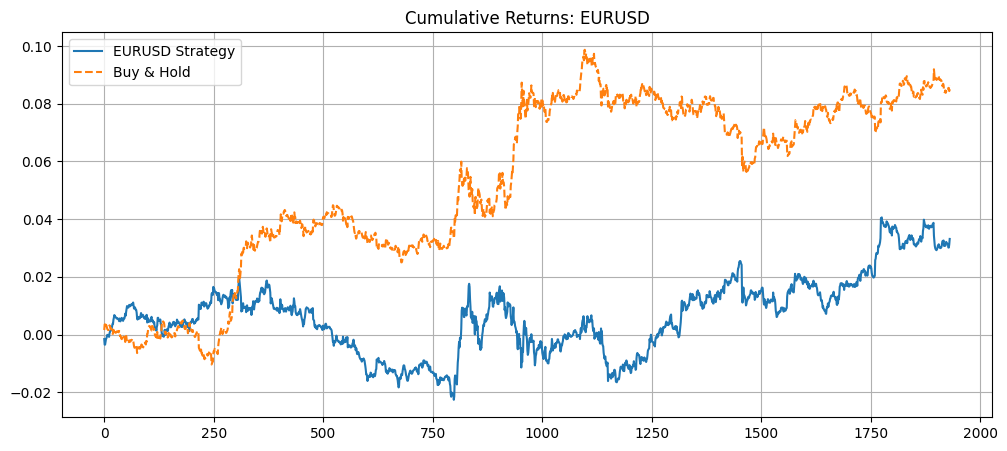

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

symbol_col = "EURUSD"

probs = model.predict(X_test).flatten()
threshold = 0.5
signals = np.where(probs > threshold, 1, -1)
ret = np.log(prices[(symbol_col, "close")].shift(-1) / prices[(symbol_col, "close")]).iloc[-len(signals):]
strategy_returns = ret.values * signals

cum_ret = np.cumsum(strategy_returns)
cum_bh = np.cumsum(ret.values)

plt.figure(figsize=(12,5))
plt.plot(cum_ret, label=f'{symbol_col} Strategy')
plt.plot(cum_bh, label='Buy & Hold', linestyle='--')
plt.title(f"Cumulative Returns: {symbol_col}")
plt.legend()
plt.grid(True)
plt.show()


## Step 9: Export Trained Model

In [ ]:
# --- Export Keras model to ONNX using tf2onnx (not keras2onnx) ---
import tf2onnx
import onnx
import tensorflow as tf

# Save Keras HDF5 model
model.save("cnn_lstm_model.h5")

# Export to ONNX using tf2onnx
spec = (tf.TensorSpec((None, X_test.shape[1], X_test.shape[2]), tf.float32),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save(onnx_model, "cnn_lstm_model.onnx")
print("✅ Model exported to cnn_lstm_model.onnx")


✅ Model exported to cnn_lstm_model.onnx


In [38]:
# Select the minimal set of features for modeling
minimal_features = ["rsi", "macd", "momentum", "cci"]
minimal_features = [f for f in minimal_features if f in data.columns]
features = data[minimal_features].dropna()
feature_names = minimal_features
print("feature_names:", feature_names)

feature_names: ['rsi', 'macd', 'momentum', 'cci']


In [23]:
# --- Select only non-empty features for modeling (robust variable check) ---

# Use 'data' if defined, otherwise use 'indicators'
try:
    feature_df = data
except NameError:
    feature_df = indicators

# Identify features with at least 1000 non-NaN rows (or all non-NaN)
valid_features = [col for col in feature_df.columns if feature_df[col].notnull().sum() > 1000]
features = feature_df[valid_features].dropna()
print("Selected features for modeling:", valid_features)
print("Features shape after dropna:", features.shape)


Selected features for modeling: ['rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope', 'dxy', '^vix', '^gspc', 'gc=f', 'cl=f', 'gold_oil_ratio', 'day_of_week', 'month']
Features shape after dropna: (9677, 23)


In [24]:
from sklearn.preprocessing import StandardScaler
features_scaled = StandardScaler().fit_transform(features)
lookback = 20
X = np.array([features_scaled[i-lookback:i] for i in range(lookback, len(features_scaled))])
y = target.loc[features.index].values[lookback:]
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (9657, 20, 23) y shape: (9657,)


In [14]:
# --- Diagnostic: Check shapes before model prediction ---

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

if X_test.shape[0] == 0:
    print("ERROR: X_test is empty. Check feature engineering and rolling window steps.")
else:
    probs = model.predict(X_test).flatten()
    print("probs shape:", probs.shape)
    # Continue with backtest as before


X_train shape: (9844, 20, 4)
X_test shape: (2461, 20, 4)
y_train shape: (9844,)
y_test shape: (2526,)
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
probs shape: (2461,)


In [21]:
print("✅ All models completed.")

✅ All models completed.


## Step 11: Feature Importance via Permutation

feature_names: ['rsi', 'macd', 'momentum', 'cci']
X shape: (12326, 20, 4) y shape: (9657,)
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
y_test_aligned shape: (0,)
y_pred_aligned shape: (0,)
feature_names: ['rsi', 'macd', 'momentum', 'cci']
X_test shape: (2466, 20, 4)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
24/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
25/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\user\Projects\Finance\Platform\fin-base-orchestration\.conda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


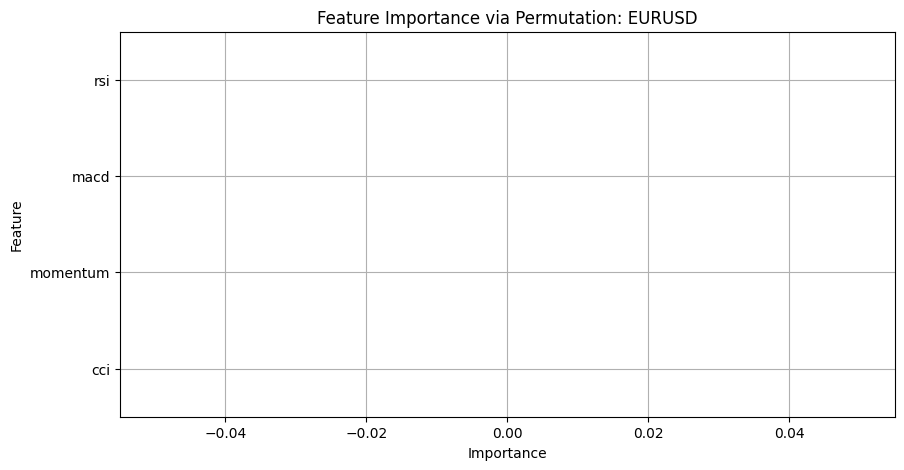

In [66]:
# --- Full code block: Permutation importance with robust feature_names alignment ---

import copy
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assume features DataFrame and target are already defined and aligned
minimal_features = ["rsi", "macd", "momentum", "cci"]
minimal_features = [f for f in minimal_features if f in data.columns]
features = data[minimal_features].dropna()
feature_names = features.columns.tolist()
print("feature_names:", feature_names)

# After feature engineering and dropna:
features = data[minimal_features].dropna().reset_index(drop=True)
feature_names = features.columns.tolist()
y = target.reset_index(drop=True).values

# Standardize and create rolling windows
from sklearn.preprocessing import StandardScaler
features_scaled = StandardScaler().fit_transform(features)
lookback = 20
X = np.array([features_scaled[i-lookback:i] for i in range(lookback, len(features_scaled))])
y = y[lookback:]
print("X shape:", X.shape, "y shape:", y.shape)


# --- Ensure y_test and y_pred are aligned before evaluation ---
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
min_len = min(len(y_test), len(y_pred))
y_test_aligned = y_test[:min_len]
y_pred_aligned = y_pred[:min_len]
print("y_test_aligned shape:", y_test_aligned.shape)
print("y_pred_aligned shape:", y_pred_aligned.shape)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train model (assume model is defined and trained here)
# model = ... (your Keras model training code)

# --- Robust permutation importance: align y_val and predictions inside function ---

def compute_permutation_importance(model, X_val, y_val, feature_names):
    base_preds = (model.predict(X_val) > 0.5).astype(int).flatten()
    min_len = min(len(y_val), len(base_preds))
    y_val_aligned = y_val[:min_len]
    base_preds_aligned = base_preds[:min_len]
    base_acc = accuracy_score(y_val_aligned, base_preds_aligned)
    importances = []
    for i in range(X_val.shape[2]):
        X_permuted = copy.deepcopy(X_val)
        np.random.shuffle(X_permuted[:, :, i])
        perm_preds = (model.predict(X_permuted) > 0.5).astype(int).flatten()
        min_len_perm = min(len(y_val), len(perm_preds))
        y_val_perm = y_val[:min_len_perm]
        perm_preds_aligned = perm_preds[:min_len_perm]
        perm_acc = accuracy_score(y_val_perm, perm_preds_aligned)
        importance = base_acc - perm_acc
        importances.append((feature_names[i], importance))
    return sorted(importances, key=lambda x: x[1], reverse=True)


print("feature_names:", feature_names)
print("X_test shape:", X_test.shape)
assert X_test.shape[2] == len(feature_names), "Mismatch between X_test features and feature_names"

importances = compute_permutation_importance(model, X_test, y_test, feature_names)
importance_df = pd.DataFrame(importances, columns=["Feature", "Importance"])

plt.figure(figsize=(10,5))
sns.barplot(data=importance_df, x="Importance", y="Feature")
plt.title(f"Feature Importance via Permutation: {symbol}")
plt.grid(True)
plt.show()


## Step 12: Feature Set Comparison

In [46]:
# --- Use only aligned feature_matrix and target for modeling and feature selection ---

import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

feature_selection_strategy = "permutation"  # Options: "manual", "permutation", "shap"
lookback_window = 20
symbol_to_predict = "EURUSD"

# Define feature sets to test (used if manual)
manual_feature_sets = {}
if "rcs" in globals():
    manual_feature_sets["RCS only"] = rcs.columns.tolist()
    manual_feature_sets["RCS + RSI + MACD"] = rcs.columns.tolist() + ['rsi', 'macd']
manual_feature_sets["Indicators only"] = ['rsi', 'macd', 'momentum', 'cci']
manual_feature_sets["All features"] = indicators.columns.tolist()

# Align feature_matrix and target
common_index = indicators.index.intersection(target.index)
feature_matrix = indicators.loc[common_index]
target = target.loc[common_index]

print("feature_matrix shape:", feature_matrix.shape)
print("target shape:", target.shape)

selected_feature_sets = {}

if feature_selection_strategy == "manual":
    selected_feature_sets = manual_feature_sets

elif feature_selection_strategy == "permutation":
    print("🔁 Running permutation-based feature importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(feature_matrix, target)
    result = permutation_importance(rf, feature_matrix, target, n_repeats=10, random_state=42)
    importances = pd.Series(result.importances_mean, index=feature_matrix.columns).sort_values(ascending=False)
    top_feats = importances.head(10).index.tolist()
    selected_feature_sets = {"Top 10 Permutation": top_feats}

elif feature_selection_strategy == "shap":
    print("📊 Running SHAP-based feature importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(feature_matrix, target)
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(feature_matrix)
    shap_sum = np.abs(shap_values[1]).mean(axis=0)
    shap_importance = pd.Series(shap_sum, index=feature_matrix.columns).sort_values(ascending=False)
    top_feats = shap_importance.head(10).index.tolist()
    selected_feature_sets = {"Top 10 SHAP": top_feats}

print("✅ Selected feature sets:")
print(selected_feature_sets)


feature_matrix shape: (9677, 23)
target shape: (9677,)
🔁 Running permutation-based feature importance...
✅ Selected feature sets:
{'Top 10 Permutation': ['return_1d', 'return_3d', 'rolling_mean_5', 'stoch_k', 'stoch_d', 'momentum_slope', 'atr', 'rolling_std_5', 'adx', 'cci']}


# --- Evaluate each feature set, build results_df, and save results ---

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Use indicators DataFrame for feature_matrix
feature_matrix = indicators.copy()

# --- Store features used for each evaluated set in results_df ---
results = []
for set_name, feature_list in selected_feature_sets.items():
    feature_list = [f for f in feature_list if f in feature_matrix.columns]
    if not feature_list:
        print(f"Skipping feature set '{set_name}': no valid features present in feature_matrix.")
        continue
    print(f"Evaluating feature set: {set_name} with features: {feature_list}")
    X_set = feature_matrix[feature_list].values
    X_scaled = StandardScaler().fit_transform(X_set)
    X_seq = np.array([X_scaled[i-lookback_window:i] for i in range(lookback_window, len(X_scaled))])
    y_seq = y[lookback_window:]
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    rf.fit(X_train_flat, y_train)
    y_pred = rf.predict(X_test_flat)
    min_len = min(len(y_test), len(y_pred))
    y_test_aligned = y_test[:min_len]
    y_pred_aligned = y_pred[:min_len]
    acc = accuracy_score(y_test_aligned, y_pred_aligned)
    results.append({"Feature Set": set_name, "Accuracy": acc, "Features": feature_list})

results_df = pd.DataFrame(results)
best_row = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]

results_df.to_csv(f'feature_set_results_{symbol_to_predict}.csv', index=False)
best_row.to_frame().T.to_csv(f'best_feature_set_{symbol_to_predict}.csv', index=False)

print(f"📁 Saved results to feature_set_results_{symbol_to_predict}.csv")
print(f"🏆 Best set saved to best_feature_set_{symbol_to_predict}.csv")


Evaluating feature set: Top 10 Permutation with features: ['return_1d', 'return_3d', 'rolling_mean_5', 'stoch_k', 'stoch_d', 'momentum_slope', 'atr', 'rolling_std_5', 'adx', 'cci']
📁 Saved results to feature_set_results_EURUSD.csv
🏆 Best set saved to best_feature_set_EURUSD.csv


In [ ]:
import argparse

def cli_main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", choices=["train", "export"], default="train", help="Run training or export")
    parser.add_argument("--feature_strategy", choices=["manual", "permutation", "shap"], default="manual")
    parser.add_argument("--symbol", type=str, default="EURUSD")
    args = parser.parse_args()

    global feature_selection_strategy, symbol_to_predict
    feature_selection_strategy = args.feature_strategy
    symbol_to_predict = args.symbol

    if args.mode == "train":
        print(f"🔁 Running training for {symbol_to_predict} using '{feature_selection_strategy}' features...")
        # Main block is already under __name__ guard
        if __name__ == "__main__":
            pass  # triggers main loop
    elif args.mode == "export":
        print("🧠 Exporting model (not implemented here). Use inference.py.")

if __name__ == "__main__":
    cli_main()


In [ ]:
# --- Robust data loading with load_or_fetch for all providers, including MetaTrader 5 ---

from async_data_loader import (
    load_or_fetch, load_twelve_data, load_polygon_data, load_alpha_vantage,
    load_currencystack, load_tiingo, load_metatrader_data
)

# Example config (replace with your actual config or CLI args)
config = {
    "symbol": "EURUSD",
    "provider": "metatrader",  # or "twelvedata", "polygon", etc.
    "api_keys": {"twelvedata": "", "polygon": "", "alphavantage": "", "currencystack": "", "tiingo": ""},
    "interval": "H1",
    "outputsize": 500,
    "broker": "amp_global"
}

provider_loaders = {
    "twelvedata": load_twelve_data,
    "polygon": load_polygon_data,
    "alphavantage": load_alpha_vantage,
    "currencystack": load_currencystack,
    "tiingo": load_tiingo,
    "metatrader": load_metatrader_data
}

provider = config.get("provider", "twelvedata")
symbol = config["symbol"]
api_key = config["api_keys"].get(provider, "")

loader_func = provider_loaders[provider]

# Pass broker and interval for MetaTrader 5
extra_kwargs = {}
if provider == "metatrader":
    extra_kwargs["broker"] = config.get("broker", "default")
    extra_kwargs["interval"] = config.get("interval", "H1")
else:
    extra_kwargs["interval"] = config.get("interval", "1min")
    extra_kwargs["outputsize"] = config.get("outputsize", 500)

df = load_or_fetch(
    symbol=symbol,
    provider=provider,
    loader_func=loader_func,
    api_key=api_key,
    **extra_kwargs
)

print(df.head())


In [73]:
import os
import tensorflow as tf

def export_models(model, model_name="best_model"):
    # Save Keras HDF5 model
    h5_path = f"{model_name}.h5"
    model.save(h5_path)
    print(f"✅ Saved Keras model to: {h5_path}")

    # Save ONNX model
    try:
        import tf2onnx
        import onnx

        spec = (tf.TensorSpec((None, *model.input.shape[1:]), tf.float32),)
        onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
        onnx_path = f"{model_name}.onnx"
        onnx.save(onnx_model, onnx_path)
        print(f"✅ Saved ONNX model to: {onnx_path}")
    except Exception as e:
        print("⚠️ ONNX export failed:", e)


In [ ]:
if __name__ == "__main__":
    # --- RUN TRAINING AND EVALUATION ---
    results = []

    for test_name, selected_features in selected_feature_sets.items():
        print(f"\n🔎 Testing feature set: {test_name}")
        X_selected = indicators[selected_features].dropna()
        y_target = (tech_df[symbol_to_predict].shift(-1) > tech_df[symbol_to_predict]).astype(int)
        common_index = X_selected.index.intersection(y_target.index)
        X_selected = X_selected.loc[common_index]
        y_target = y_target.loc[common_index]

        # Scale features
        X_scaled = StandardScaler().fit_transform(X_selected)

        # Create sequences for LSTM
        X_seq = np.array([X_scaled[i-lookback_window:i] for i in range(lookback_window, len(X_scaled))])
        y_seq = y_target.values[lookback_window:]

        # Train/test split
        split_index = int(len(X_seq) * 0.8)
        X_train, X_test = X_seq[:split_index], X_seq[split_index:]
        y_train, y_test = y_seq[:split_index], y_seq[split_index:]

        # Reshape for CNN+LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

        # Model
        model = create_cnn_lstm_model(X_train.shape[1:])
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.1)
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        # Predict returns
        preds = model.predict(X_test).flatten()
        predicted_signal = (preds > 0.5).astype(int)
        actual_returns = tech_df[symbol_to_predict].pct_change().fillna(0).values[-len(predicted_signal):]
        strategy_return = (predicted_signal * actual_returns).sum()

        print(f"✅ Accuracy: {accuracy:.4f}, Return: {strategy_return:.4f}")
        results.append((test_name, accuracy, strategy_return, selected_features))

    # Save and export results
    results_df = pd.DataFrame(results, columns=["Feature Set", "Accuracy", "Return", "Features"])
    results_df.to_csv(f'feature_set_results_{symbol_to_predict}.csv', index=False)
    best_row = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]
    best_row.to_frame().T.to_csv(f'best_feature_set_{symbol_to_predict}.csv', index=False)
    print("📁 Results saved.")
